# Navigation
---


In [1]:
from mlagents_envs.environment import UnityEnvironment
import numpy as np
import torch
import random
from collections import deque
from dqn_agent import Agent
import os
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 

In [2]:
ENV_PATH = "environment"

In [3]:
!pip install torchvision

In [4]:
import torchvision.transforms as transforms

### 1. Initialise customised Banana Collecter environment

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
def initialise_env(ENV_PATH):
    # env = UnityEnvironment(file_name=ENV_PATH)
    env = UnityEnvironment(file_name="environment", seed=1, side_channels=[],base_port = 5004)
    env.step()
    # in this project, we are only using one agent, so we will only work on the first `brain` in the environmet
    # get the default brain
    # brain_name = env.brain_names[0]
    brain_name = list(env.behavior_specs.keys())[0]
    # brain = env.brains[brain_name]
    brain = env.behavior_specs[brain_name]
    return env, brain, brain_name

In [6]:
env, brain, brain_name = initialise_env(ENV_PATH)

In [7]:
print(brain_name)

My Behavior?team=0


In [8]:
# 先让他走几步直到需要交互
env.step()

### State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 



### 2. Initialise the agent

In [9]:
spec = env.behavior_specs['My Behavior?team=0']
print(spec)

BehaviorSpec(observation_specs=[ObservationSpec(shape=(128, 128, 3), dimension_property=(<DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.NONE: 1>), observation_type=<ObservationType.DEFAULT: 0>, name='CameraSensor'), ObservationSpec(shape=(0,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='VectorSensor'), ObservationSpec(shape=(4,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='VectorSensor_size4')], action_spec=ActionSpec(continuous_size=0, discrete_branches=(5,)))


In [10]:
# reset the environment
#env_info = env.reset(train_mode=True)[brain_name]
env_info = env.reset()
#action_size = brain.vector_action_space_size
#state_size = len(env_info.vector_observations[0])
#agent = Agent(state_size=state_size, action_size=action_size, seed=0)

In [11]:
print(env_info)

None


In [12]:
action_size = list(brain.action_spec)[1][0]

In [13]:
decision_steps, terminal_steps = env.get_steps(brain_name)

In [14]:
# state = np.array(decision_steps.obs).resize(84,84)
# #state = np.reshape(state,-1)

In [15]:
state_size = len(brain.observation_specs[0])

In [16]:
print(state_size)

4


In [17]:
#state_size = len(env_info.vector_observations[0])
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

In [18]:
device = torch.device("cpu")

### 3. Train agent

In [19]:
import numpy as np
a = []
for act in range(5):
    a.append(spec.action_spec.empty_action(1))
    a[act].add_discrete(np.int32([[act]]))
stop = a[0]
forward = a[1]
backward = a[2]
turn_right = a[3]
turn_left = a[4]

In [20]:
def show_images(x):
    """ plots first ncols images in a batch """
    x = x.squeeze(1).T

    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    ax.imshow(x, cmap="Greys")
    ax.axis('off')
    plt.show()

In [21]:
# import torchvision.transforms as transforms

def train_dqn(agent, n_episodes=2, max_t=15, eps_start=1.0, eps_end=0.1, eps_decay=0.98):

    """Deep Q-Learning.

    Params

    ======

        n_episodes (int): maximum number of training episodes

        max_t (int): maximum number of timesteps per episode

        eps_start (float): starting value of epsilon, for epsilon-greedy action selection

        eps_end (float): minimum value of epsilon

        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon

    """

    scores = []                        # list containing scores from each episode

    scores_window = deque(maxlen=100)  # last 100 scores

    eps = eps_start                    # initialize epsilon
    reward = 0
    rewards = 0

    for i_episode in range(1, n_episodes+1):

        #state = brain.observation_specs[0]

        decision_steps, terminal_steps = env.get_steps(brain_name)

        state = np.moveaxis(decision_steps.obs[0], -1, 0)

        # 看有几个agent

        tracked_agent = -1

        done = False

        score = 0

        for t in range(max_t):

            if tracked_agent == -1 and len(decision_steps) >= 1:

                tracked_agent = decision_steps.agent_id[0]
#             show_images(state)
                

            #env.set_actions(behavior_name, forward)

            action = agent.act(state, eps)

#             packed_action = spec.action_spec.empty_action(1)

#             packed_action.add_discrete(np.int32([[action]]))

#             print(action, brain_name)
#             print(action)

            env.set_actions(brain_name, a[action])

            env.step()

           

            decision_steps, terminal_steps = env.get_steps(brain_name)

#             print("~~~~~~~~~~~~~~~~~~~~~~")

#             if tracked_agent in decision_steps: # The agent requested a decision

#                 episode_rewards += decision_steps[tracked_agent].reward

#             if tracked_agent in terminal_steps: # The agent terminated its episode

#                 episode_rewards += terminal_steps[tracked_agent].reward

#                 done = True

            next_state =  np.moveaxis(decision_steps.obs[0], -1, 0)   # get the next state
    
            if len(next_state) == 0:
                continue

            if tracked_agent in decision_steps:# The agent requested a decision

                reward += decision_steps[tracked_agent].reward  # get the reward

                agent.step(state, action, reward, next_state, False)

            if tracked_agent in terminal_steps: # The agent terminated its episode

                rewards += terminal_steps[tracked_agent].reward# get the reward

                agent.step(state, action, reward, next_state, True)

                break

            # done = env_info.local_done[0]  

            # print(terminal_steps[0])

            # _,_, done = terminal_steps[0]

            # done = False

            agent.step(state, action, reward, next_state, done)

            state = next_state

            score += reward

            # if done:

            #     break

        scores_window.append(score)       # save most recent score

        scores.append(score)              # save most recent score
#         print("~~~~~~~~~~~~~2~~~~~~~~~~~~~~~~~")
        print(scores_window)

        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

#         if i_episode % 100 == 0:

#             print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

#             torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

#             print('saved temporary learned weight')

#         if np.mean(scores_window)>=13.0:

#             print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))

#             torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

#             print('agent done training')

#             break

    return scores


In [22]:
# if os.path.isfile('./checkpoint.pth'):
#     # load the weights from file
#     agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
scores = train_dqn(agent, n_episodes=100)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
deque([80.0], maxlen=100)
Episode 1	Average Score: 80.000.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
deque([80.0, 290.0], maxlen=100)
Episode 2	Average Score: 185.000.9025
0.9025
0.9025
0.9025
0.9025
0.9025
0.9025
0.9025
0.9025
0.9025
0.9025
0.9025
0.9025
0.9025
deque([80.0, 290.0, 300.0], maxlen=100)
Episode 3	Average Score: 223.330.8573749999999999
0.8573749999999999
0.8573749999999999
0.8573749999999999
0.8573749999999999
0.8573749999999999
0.8573749999999999
0.8573749999999999
0.8573749999999999
0.8573749999999999
0.8573749999999999
0.8573749999999999
0.8573749999999999
0.8573749999999999
deque([80.0, 290.0, 300.0, 377.0], maxlen=100)
Episode 4	Average Score: 261.750.8145062499999999
0.8145062499999999
0.8145062499999999
0.8145062499999999
0.8145062499999999
0.8145062499999999
0.8145062499999999
0.8145062499999999
0.8145062499999999
0.8145062499999999
0.8145062499999999
0.8145062499999999
deque([80

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 3, 0, 128, 128]

In [28]:
if os.path.isfile('./checkpoint.pth'):
    # load the weights from file
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

#### 4. Plot performance

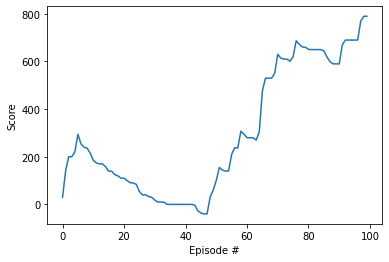

In [22]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a trained agent!

In [8]:
def watch_banana_agent(agent, env, n_episodes=4, n_steps=300):

                                   
    
    for episode in range(n_episodes):
        
        env_info = env.reset(train_mode=False)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        
        for step in range(n_steps):

            action = agent.act(state)                 # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break

        print("Score: {}".format(score))

In [10]:
watch_banana_agent(agent, env)

Score: 3.0
Score: 9.0
Score: 8.0
Score: 20.0


In [15]:
env.close()